[115.85679142 152.26153716 178.87449059 162.93500815 107.02820697
 105.19141146 118.38288501 125.3769803  102.88054011 206.71326136] ...


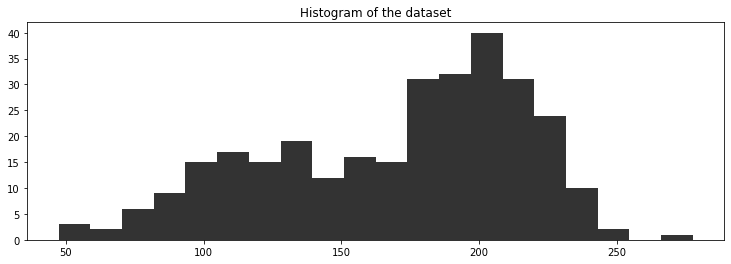

In [1]:
%matplotlib inline
import scipy.stats as stats
from IPython.core.pylabtools import figsize
import matplotlib.pyplot as plt
import numpy as np
figsize(12.5, 4)
data = np.loadtxt("data/mixture_data.csv", delimiter=",")

plt.hist(data, bins=20, color="k", histtype="stepfilled", alpha=0.8)
plt.title("Histogram of the dataset")
plt.ylim([0, None]);
print(data[:10], "...")

In [61]:
import pymc3 as pm
import theano.tensor as T

with pm.Model() as model:
    #p1 = pm.Uniform('p', 0, 1, testval=0.9)
    #p2 = 1 - p1
    #p = T.stack([p1, p2])
    p = pm.Uniform('p', 0, 1)
    assignment = pm.Bernoulli("assignment", p, testval=0)
    
print("prior assignment, with p = %.2f:" % p1.tag.test_value)
print(assignment.tag.test_value)

prior assignment, with p = 0.90:
0


In [62]:
with model:
    sds = pm.Uniform("sds", 0, 100, shape=2)
    centers = pm.Normal("centers", 
                        mu=np.array([120, 190]), 
                        sd=np.array([10, 10]), 
                        shape=2)
    
    #center_i = pm.Deterministic('center_i', centers[assignment])
    center_i = pm.math.switch(assignment == 0, centers[0], centers[1])
    #sd_i = pm.Deterministic('sd_i', sds[assignment])
    sd_i = pm.math.switch(assignment == 0, sds[0], sds[1])
    
    # and to combine it with the observations:
    observations = pm.Normal("obs", mu=center_i, sd=sd_i)#, observed=data)


AsTensorError: Cannot cast True or False as a tensor variable. Please use np.array(True) or np.array(False) if you need these constants. This error might be caused by using the == operator on Variables. v == w does not do what you think it does, use theano.tensor.eq(v, w) instead.

In [59]:
print("Random assignments: ", assignment.random(), "...")
print("Assigned center: ", center_i.tag.test_value, "...")
print("Assigned standard deviation: ", sd_i.tag.test_value)

Random assignments:  1 ...
Assigned center:  120.0 ...
Assigned standard deviation:  50.0


In [60]:
with model:
    step = pm.Metropolis()
    #step1 = pm.Metropolis(vars=[p, sds, centers])    
    #step2 = pm.CategoricalGibbsMetropolis(vars=[assignment])
    trace = pm.sample(25_000, step=step)

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [obs]
>Metropolis: [centers]
>Metropolis: [sds]
>Metropolis: [assignment]
>Metropolis: [p]


RuntimeError: Chain 0 failed.

In [55]:
trace["assignment"].min()

0

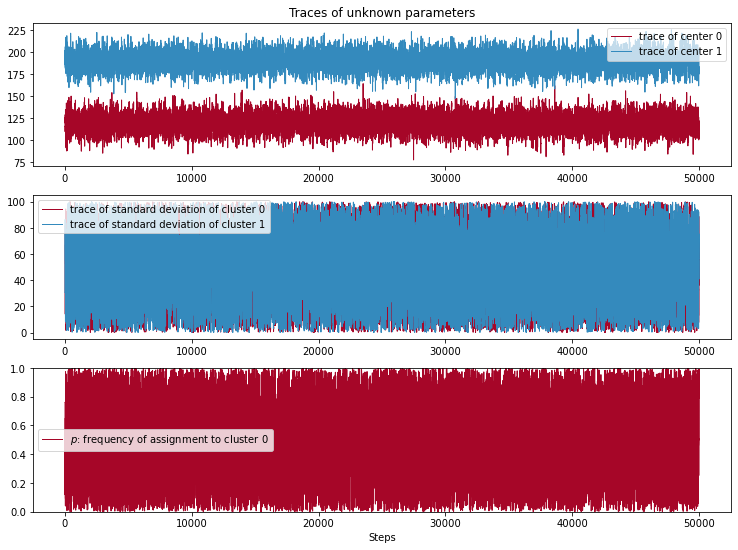

In [56]:
figsize(12.5, 9)
plt.subplot(311)
lw = 1
center_trace = trace["centers"]

colors = ["#348ABD", "#A60628"] if center_trace[-1, 0] > center_trace[-1, 1] \
    else ["#A60628", "#348ABD"]

plt.plot(center_trace[:, 0], label="trace of center 0", c=colors[0], lw=lw)
plt.plot(center_trace[:, 1], label="trace of center 1", c=colors[1], lw=lw)
plt.title("Traces of unknown parameters")
leg = plt.legend(loc="upper right")
leg.get_frame().set_alpha(0.7)

plt.subplot(312)
std_trace = trace["sds"]
plt.plot(std_trace[:, 0], label="trace of standard deviation of cluster 0",
     c=colors[0], lw=lw)
plt.plot(std_trace[:, 1], label="trace of standard deviation of cluster 1",
     c=colors[1], lw=lw)
plt.legend(loc="upper left")

plt.subplot(313)
p_trace = trace["p"]
plt.plot(p_trace, label="$p$: frequency of assignment to cluster 0",
     color=colors[0], lw=lw)
plt.xlabel("Steps")
plt.ylim(0, 1)
plt.legend();